### Building the Constructing Auxiliary Time Series Method: A Tutorial for Time Series Forecasting with CATS

This notebook covers:

- Structure of the CATS module
- Creating the main predictor: templates and customization
- Hyper-parameter settings for CATS
- Training CATS on a simple generated dataset
- Visualizing ATS (Auxiliary Time Series), OTS (Original Time Series), first-stage predictions, and final forecasts
- How to choose the most suitable main predictor
- Comparing performances of various main predictors within CATS

First, let's outline the overall structure of CATS. The forward path for CATS can be illustrated as: `Preprocessing stage` -> `ATS construction` -> `Applying Three Principles` -> `Main predictor` -> `ATS Projection / OTS Shortcut` -> `Inverse processing stage`.

In [1]:
# pip install torch numpy matplotlib

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import copy
import random

# set random seed
fix_seed = 2024
random.seed(fix_seed)
torch.manual_seed(fix_seed)
np.random.seed(fix_seed)

class CATS(nn.Module):
    def __init__(self, configs):
        super().__init__()
        self.eps = 1e-7
        ########## Input Data Format ########## 
        # seq_len: L_I, pred_len: L_P
        self.seq_len = configs.seq_len
        self.pred_len = configs.pred_len
        # in_channels: C
        self.in_channels = configs.enc_in
        # time_emb_dim: number of dimension of the optional timestamp embeddings
        self.time_emb_dim = configs.time_emb_dim
        # total number of input channels
        self.in_channels_full = self.in_channels + self.time_emb_dim
        
        # If you are only using a subset of the input series as the OTS and treating the remaining input series as ATS, you can set `number_of_targets` to a value greater than 0.
        if configs.number_of_targets > 0:
            self.preserving_channels = configs.number_of_targets
        else:
            self.preserving_channels = self.in_channels

        ########## Preprocessing ##########
        # Change the preprocessing method for input and output here, last-value demeaning by default
        self.preprocessing_method = 'lastvalue'#'standardization'#'auel'#'none'
        self.preprocessing_detach = True
        self.preprocessing_affine = False
        self.channel_w = nn.Parameter(torch.ones(self.preserving_channels), requires_grad=True)
        self.channel_b = nn.Parameter(torch.zeros(self.preserving_channels), requires_grad=True)
        if self.preprocessing_method == 'auel':
            self.conv_size = [8, 16, 64]
            self.ema_alpha = nn.Parameter(0.9*torch.ones(self.in_channels))
            self.std_weights = nn.Parameter(torch.cat([0.5*torch.ones(len(self.conv_size), self.in_channels), 
                                                          torch.ones(1, self.in_channels)]))

        ########## ATS Constructors (OTS -> ATS) ##########
        # The output number of ATS channels, $n_m$, for $F^{[\mathtt{Conv}]}_m (X_I)$
        self.F_conv_output = configs.F_conv_output
        # The output number of ATS channels, $n_m$, for $F^{[\mathtt{NOConv}]}_m (X_I)$
        self.F_noconv_output = configs.F_noconv_output
        # The output expanding rate of ATS channels, $v$, for $F^{[\mathtt{IConv}]}_{m} (X_I)$ with output channels $v \cdot C$
        self.F_gconv_output_rate = configs.F_gconv_output_rate
        # The output number of ATS channels, $n_m$, for $F^{[\mathtt{Lin}]}_m (X_I)$
        self.F_lin_output = configs.F_lin_output
        # The output expanding rate of ATS channels, $v$, for $F^{[\mathtt{Id}]}_{m} (X_I)$ with output channels $v \cdot C$
        self.F_id_output_rate = configs.F_id_output_rate
        # The output number of ATS channels, $n_m$, for $F^{[\mathtt{Emb}]}_m (X_I)$
        self.F_emb_output = configs.F_emb_output
        # calculate the $n_m$ for IConv and Id
        self.F_gconv_output = int(self.F_gconv_output_rate*self.preserving_channels)
        self.F_id_output = int(self.preserving_channels*self.F_id_output_rate)

        # The components of ATS channels. Note that we are using two types of Conv and NOConv with different kernel size 
        self.feature_pool_desc = [self.F_conv_output, 
                                  self.F_conv_output, 
                                  self.F_noconv_output, 
                                  self.F_noconv_output, 
                                  self.F_gconv_output, 
                                  self.F_lin_output, 
                                  self.F_id_output, 
                                  self.F_emb_output,
                                  self.time_emb_dim,
                                  self.in_channels
                                 ]

        # shared MLP upscaling ratio in channel sparsity module and predictors
        self.mlp_ratio = configs.mlp_ratio

        # The two Conv ATS constructors $F^{[\mathtt{Conv}]}_1 (X_I)$ and $F^{[\mathtt{Conv}]}_2 (X_I)$
        self.input_conv2 = nn.Conv1d(in_channels=self.in_channels_full, out_channels=self.F_conv_output, kernel_size=49, padding=24)
        self.input_conv2_alter = nn.Conv1d(in_channels=self.in_channels_full, out_channels=self.F_conv_output, kernel_size=193, padding=96)
        # The two NOConv ATS constructors $F^{[\mathtt{NOConv}]}_3 (X_I)$ and $F^{[\mathtt{NOConv}]}_4 (X_I)$
        self.input_conv = Conv1dNonOverlapping(in_channels=self.in_channels_full, out_channels=self.F_noconv_output, input_length=self.seq_len, kernel_size=12, groups=1)
        self.input_conv_alter = Conv1dNonOverlapping(in_channels=self.in_channels_full, out_channels=self.F_noconv_output, input_length=self.seq_len, kernel_size=24, groups=1)
        # Independent Convolution
        self.input_conv_grouped2 = nn.Conv1d(in_channels=self.preserving_channels, out_channels=self.F_gconv_output, kernel_size=49, padding=24, groups=self.preserving_channels)
        # Linear Projection
        self.input_conv_1x1 = nn.Conv1d(in_channels=self.in_channels_full, out_channels=self.F_lin_output, kernel_size=1, padding=0)
        # Embedding
        self.pure_emb = nn.Parameter(torch.randn(1, self.seq_len, self.F_emb_output))

        ########## Main Predictor ##########
        # which predictor to use
        self.predictor = configs.predictor
        print(f'Current Predictor: {self.predictor}')

        # A interface to use different main predictor in CATS is provided here. By changing the predictor_configs, you can personalize the hyper-parameters for different predictors. 
        # The implementation of the main predictors will be provided in the following sections.
        # In the first part of this notebook, we will use the implementation of a 2-layer MLP, the `DefaultPredictor` here, as an example.
        # To customize your own predictor, you can write your code as the `DefaultPredictor` class in the next block and add one if-statement here
        predictor_configs = copy.deepcopy(configs)
        predictor_configs.enc_in = sum(self.feature_pool_desc)
        predictor_configs.dec_in = sum(self.feature_pool_desc)
        predictor_configs.c_out = sum(self.feature_pool_desc)
        if self.predictor == 'Default':
            self.Predictor = DefaultPredictor(d_in=self.seq_len, d_ff=self.mlp_ratio*self.seq_len, d_out=self.pred_len, dropout=configs.predictor_dropout)
        
        # We will show examples of other predictors in the later part of this notebook
        elif self.predictor == 'Simple':
            self.Predictor = SimplePredictor(d_in=self.seq_len, d_out=self.pred_len)
        elif self.predictor == 'MLP':
            self.Predictor = MLPPredictor(d_in=self.seq_len, d_ff=self.mlp_ratio*(self.seq_len+self.pred_len), d_out=self.pred_len, dropout=configs.predictor_dropout)
        elif self.predictor == 'NLinear':
            self.Predictor = LinearPredictor(d_in=self.seq_len, d_out=self.pred_len)
        elif self.predictor == 'Agg':
            self.Predictor = AggregatingPredictor(d_in=self.seq_len, d_out=self.pred_len, n_channels=predictor_configs.enc_in, kernel_size=32, token_size=64, dropout=0.5, independent=True)
        elif self.predictor == 'Mean':
            self.Predictor = MeanAggregationPredictor(pred_len=self.pred_len)
        elif self.predictor == 'IndependentLinear':
            self.Predictor = IndependentLinearPredictor(d_in=self.seq_len, d_out=self.pred_len, n_channels=predictor_configs.enc_in, split_ratio=1)
        elif self.predictor == 'GroupedIndependent':
            self.Predictor = GroupedLinearPredictor(d_in=self.seq_len, d_out=self.pred_len, grouping=self.feature_pool_desc[0:-1] + [1 for i in range(self.in_channels)])
        elif self.predictor == 'MoE':
            self.Predictor = MoEPredictor(d_in=self.seq_len, d_ff=4096, d_out=self.pred_len, dropout=configs.predictor_dropout, n_experts=4)

        # The predictors below are not included in this notebook, please refer to their corresponding original code repository for the implementation
        elif self.predictor == 'PatchTST':
            predictor_configs.e_layers = 3
            predictor_configs.n_heads = 4
            predictor_configs.d_model = 16
            predictor_configs.d_ff = 128
            predictor_configs.dropout = 0.3
            predictor_configs.fc_dropout = 0.3
            predictor_configs.head_dropout = 0
            predictor_configs.patch_len = 16
            predictor_configs.stride = 8
            predictor_configs.revin = 1
            self.Predictor = PatchTST(predictor_configs)
        elif self.predictor == 'DLinear':
            self.Predictor = DLinear(predictor_configs)
        elif self.predictor == 'Autoformer':
            predictor_configs.e_layers = 2
            predictor_configs.d_layers = 1
            predictor_configs.factor = 3
            self.Predictor = Autoformer(predictor_configs)
        elif self.predictor == 'Informer':
            predictor_configs.e_layers = 2
            predictor_configs.d_layers = 1
            predictor_configs.factor = 3
            self.Predictor = Informer(predictor_configs)
        elif self.predictor == 'TimesNet':
            predictor_configs.label_len = 48
            predictor_configs.factor = 3
            self.Predictor = TimesNet(predictor_configs)
        elif self.predictor == 'Transformer':
            predictor_configs.e_layers = 2
            predictor_configs.d_layers = 1
            predictor_configs.factor = 3
            self.Predictor = Transformer(predictor_configs)
        elif self.predictor == 'TiDE':
            predictor_configs.e_layers = 2
            predictor_configs.d_layers = 2
            predictor_configs.label_len = 48
            predictor_configs.factor = 3
            predictor_configs.d_model = 256
            predictor_configs.d_ff = 256
            predictor_configs.dropout = 0.3
            self.Predictor = TiDE(predictor_configs)
        elif self.predictor == 'NBeats':
            self.Predictor = NBeats(predictor_configs)
        elif self.predictor == 'FITS':
            predictor_configs.individual = 0
            self.Predictor = FITS(predictor_configs)
        self.predictor_configs = predictor_configs

        ########## Three Key Principles ##########
        # $\mathcal{L}_{\text{cont}}$
        self.continuity_beta = configs.continuity_beta

        # Whether to use temporal sparsity module: True or False
        self.gated = configs.temporal_gate
        # independent linear layers in temporal sparsity module
        self.generate_self_mask = GroupedLinears(self.seq_len, 1, n=predictor_configs.enc_in, zero_init=True, init=0)
        self.mask_generate_linspace = nn.Parameter(torch.linspace(1, 0, steps=self.seq_len), requires_grad=False)

        # Whether to use channel sparsity module: True or False
        self.channel_sparsity = configs.channel_sparsity
        # channel sparsity module
        self.channel_selection = SelectiveChannelModule(input_length=self.seq_len, input_channels=self.in_channels_full, 
                                                        expanded_channels=sum(self.feature_pool_desc)+self.time_emb_dim, 
                                                        drop_channels=0, mlp_ratio=self.mlp_ratio)

        ########## ATS -> OTS ##########
        # Project ATS back to OTS channels
        self.output_conv_1x1 = nn.Conv1d(in_channels=predictor_configs.dec_in+self.time_emb_dim, out_channels=self.preserving_channels, kernel_size=1, padding=0)
        torch.nn.init.zeros_(self.output_conv_1x1.weight)

    # Implementation of temporal sparsity module
    def gate(self, x, generated_mask, linspace, return_mask=False):
        mask_infer = -generated_mask(x) # B 1 C, a, a \in (-inf, 0)
        gate_len = x.shape[1]
        mask_infer = linspace.reshape(1, gate_len, 1).repeat(mask_infer.shape[0], 1, mask_infer.shape[-1]) * mask_infer + 1 # a(t-L_I)+1
        # straigh through estimator
        mask_stop = mask_infer - mask_infer.detach() + (mask_infer > 0).int().detach()
        x = x * mask_stop
        if return_mask:
            return x, mask_stop
        else:
            return x

    # ATS construction
    def encoder(self, x, x_mark_enc=None, x_dec=None, x_mark_dec=None,
                enc_self_mask=None, dec_self_mask=None, dec_enc_mask=None):
        x = torch.cat([
            self.input_conv2(x.permute(0,2,1)).permute(0,2,1) if self.F_conv_output > 0 else torch.Tensor([]).to(x.device),
            self.input_conv2_alter(x.permute(0,2,1)).permute(0,2,1) if self.F_conv_output > 0 else torch.Tensor([]).to(x.device),
            self.input_conv(x.permute(0,2,1)).permute(0,2,1) if self.F_noconv_output > 0 else torch.Tensor([]).to(x.device),
            self.input_conv_alter(x.permute(0,2,1)).permute(0,2,1) if self.F_noconv_output > 0 else torch.Tensor([]).to(x.device),
            self.input_conv_grouped2(x[:, :, -self.preserving_channels:].permute(0,2,1)).permute(0,2,1) if self.F_gconv_output_rate > 0 else torch.Tensor([]).to(x.device),
            self.input_conv_1x1(x.permute(0,2,1)).permute(0,2,1) if self.F_lin_output > 0 else torch.Tensor([]).to(x.device),
            *[x[:, :, -self.preserving_channels:] for i in range(self.F_id_output_rate)],
            self.pure_emb.repeat(x.shape[0], 1, 1),
            x
        ], dim=-1) # B, L_I, total_ATS_channels+C
        return x

    # Main predictor
    def predictor_(self, x, x_mark_enc=None, x_dec=None, x_mark_dec=None):
        x_pred = self.Predictor(x.clone(), x_mark_enc, x_dec, x_mark_dec)
        x = torch.cat([x.clone(), x_pred], dim=1) # B L latent
        return x

    # Project ATS channels back to OTS channels, maintaining OTS shortcut
    def decoder(self, x, channel_attn_score_decode):
        x_resid = self.output_conv_1x1((x*channel_attn_score_decode).permute(0,2,1)).permute(0,2,1) # B L C
        output = x.clone()
        output[:, -self.pred_len:, -self.preserving_channels:] = x[:, -self.pred_len:, -self.preserving_channels:] + x_resid[:, -self.pred_len:, :]
        return output

    # Implementation of Last-value Demeaning / RevIn / AUEL. Last-value Demeaning is used by default.
    def preprocessing(self, x, x_output=None, cutoff=None, preprocessing_method=None, preprocessing_detach=None, preprocessing_affine=None):
        eps = self.eps
        x_orig = x.clone()
        if preprocessing_method is None: preprocessing_method = self.preprocessing_method
        if preprocessing_detach is None: preprocessing_detach = self.preprocessing_detach
        if preprocessing_affine is None: preprocessing_affine = self.preprocessing_affine
        if self.preprocessing_affine:
            x = x * self.channel_w + self.channel_b
        if preprocessing_method == 'lastvalue':
            mean = x[:,-1:,:]
            std = torch.ones(1, 1, x.shape[-1]).to(x.device)
        elif preprocessing_method == 'standardization':
            if cutoff is None:
                mean = x.mean(dim=1, keepdim=True)
                std = x.std(dim=1, keepdim=True) + eps
            else:
                n_elements = cutoff.sum(dim=1, keepdim=True) # B L C -> B 1 C
                # x = x * cutoff # already done
                mean = x.sum(dim=1, keepdim=True) / (n_elements+eps).detach()
                sst = (cutoff*((torch.square(x - mean))**2)).sum(dim=1, keepdim=True)
                std = torch.sqrt(sst / (n_elements-1+eps)) + eps
                std = std.detach()
                std = torch.ones(1, 1, x.shape[-1]).to(x.device)
        elif preprocessing_method == 'auel':
            anchor_context = ema_3d(x[:, 0:(self.seq_len), :], alpha=self.ema_alpha[0:x.shape[-1]].clip(0.000001, 0.999999))
            std = weighted_std(x[:, 0:(self.seq_len), :], self.conv_size+[self.seq_len], gate_activation(self.std_weights*2).unsqueeze(0).repeat(x.shape[0], 1, 1)[:, :, 0:x.shape[-1]]).clip(1e-4, 5000)+eps
            mean = anchor_context
        elif preprocessing_method == 'none':
            mean = torch.zeros(1, 1, x.shape[-1]).to(x.device)
            std = torch.ones(1, 1, x.shape[-1]).to(x.device)
        if x_output is None:
            x_output = x_orig.clone()
        if self.preprocessing_detach:
            x_output = (x_output - mean.detach())/std.detach()
        else:
            x_output = (x_output - mean)/std
        if self.preprocessing_affine:
            x_output = (x_output - self.channel_b) / self.channel_w
        return x_output, mean, std

    # Inverse processing stage of the preprocessing method used above
    def inverse_processing(self, x, mean, std):
        x = x.clone()
        if self.preprocessing_affine:
            x = (x - self.channel_b)/self.channel_w
        x = x*std + mean
        return x

    # In this example, only the input OTS `x_enc` is needed
    def forward(self, x_enc, x_mark_enc=None, x_dec=None, x_mark_dec=None,
                enc_self_mask=None, dec_self_mask=None, dec_enc_mask=None, 
                return_mask=False, train=False):
        # x_enc: [Batch, Input length, Channel]
        # Apply preprocessing method
        x_preprocessed, mean, std = self.preprocessing(x_enc[:, :, -self.preserving_channels:], x_output=x_enc[:, :, -self.preserving_channels:])
        x = torch.cat([x_enc[:, :, 0:-self.preserving_channels], x_preprocessed], dim=-1)
        
        # Add additional timestamp embedding if applicable (not used in this notebook example)
        if self.time_emb_dim:
            x_enc = torch.cat([x_mark_enc, x], dim=-1)
        else:
            x_enc = x

        # OTS -> ATS

        # Calculate the channel attention score with the channel sparsity module, for both ATS and OTS
        channel_attn_score = self.channel_selection(x_enc) if self.channel_sparsity else torch.ones(1, 1, sum(self.feature_pool_desc)+self.time_emb_dim, device=x_enc.device)
        channel_attn_score_decode = torch.cat([torch.ones_like(channel_attn_score[:, :, 0:-(self.preserving_channels+self.time_emb_dim)]).to(x.device), channel_attn_score[:, :, -(self.preserving_channels+self.time_emb_dim):]], dim=-1).clone()
        channel_attn_score = torch.cat([channel_attn_score[:, :, 0:-(self.preserving_channels+self.time_emb_dim)], torch.ones(channel_attn_score.shape[0], 1, self.preserving_channels, device=x_enc.device)], dim=-1)
        
        # ATS construction
        x = self.encoder(x_enc)

        # Apply channel attention score
        x = channel_attn_score * x

        # Calculate continuity loss
        cnt_loss = continuity_loss(x)*self.continuity_beta

        # Apply temporal sparsity
        if return_mask:
            x, mid_mask = self.gate(x, self.generate_self_mask, self.mask_generate_linspace, return_mask=True)
        else:
            x = self.gate(x, self.generate_self_mask, self.mask_generate_linspace)

        # Some predictors require zero-filled decoder input:
        # Align Input Format for Different Predictors
        x_dec = torch.zeros(x.shape[0], self.pred_len, x.shape[-1], device=x.device)
        if self.predictor_configs.label_len:
            x_dec = torch.cat([x[:, -self.predictor_configs.label_len:, :], x_dec], dim=1)

        # Predictor
        x = self.predictor_(x, x_mark_enc, x_dec, x_mark_dec)

        # Take snapshot for the visualization of ATS 
        x_predictor_snapshot = x.detach().clone()
        x_predictor_snapshot[:, :, -self.preserving_channels:] = self.inverse_processing(x_predictor_snapshot[:, :, -self.preserving_channels:], mean, std).detach()

        # Add Timestep embedding again, if applicable (not used in this notebook example)
        if self.time_emb_dim:
            timestamp_embedding = torch.cat([x_mark_enc, x_mark_dec[:, -self.pred_len:, :]], dim=1)
            x = torch.cat([timestamp_embedding, x], dim=-1)

        # Decoder
        x_dec = self.decoder(x, channel_attn_score_decode)

        # Inverse processing stage of the preprocessing method
        x = x_dec[:, -self.pred_len:, -self.in_channels:]
        x[:, :, -self.preserving_channels:] = self.inverse_processing(x[:, :, -self.preserving_channels:], mean, std)

        if train:
            return x, cnt_loss

        # for visualization
        if return_mask:
            return x, mid_mask, x_predictor_snapshot
        else:
            return x # [Batch, Output length, Channel]

Also, we need to construct several key modules, outlined as follows:

In [2]:
# Building Key Modules

# Non-overlapping Convolution
class Conv1dNonOverlapping(nn.Module):
    def __init__(self, in_channels, out_channels, input_length, kernel_size, groups=1):
        super(Conv1dNonOverlapping, self).__init__()
        extra_length = (kernel_size - (input_length % kernel_size)) % kernel_size
        padding = extra_length // 2
        self.input_length = input_length
        self.groups = groups
        self.kernel_size = kernel_size
        self.out_channels = out_channels
        self.conv1d = nn.Conv1d(in_channels=in_channels, out_channels=out_channels*kernel_size, kernel_size=kernel_size, stride=kernel_size, padding=padding, groups=groups)
        
    def forward(self, x):
        # x: B, C, L
        x = self.conv1d(x)
        conv_len = x.shape[-1]
        x = x.reshape(x.shape[0], self.out_channels, self.kernel_size, conv_len)  # B G*C Ks Lout
        x = x.permute(0, 1, 3, 2) # B G*C Lout Ks
        x = x.reshape(x.shape[0], self.out_channels, conv_len*self.kernel_size) # B G*C Lout*Ks
        padding = self.input_length - x.shape[-1]
        x = F.pad(x, (padding, 0))
        return x

# Implementation of Parallelized Independent Linear Layers
class GroupedLinears(nn.Module):
    def __init__(self, in_d, out_d, n=16, zero_init=True, init=0, split_ratio=1):
        super(GroupedLinears, self).__init__()
        self.n = n
        self.split_ratio = min(split_ratio, n)
        base_segment_size = n // self.split_ratio
        remainder = n % self.split_ratio
        self.segment_sizes = [base_segment_size + (1 if i < remainder else 0) for i in range(self.split_ratio)]
        self.weights = nn.ParameterList()
        self.biases = nn.ParameterList()
        for segment_size in self.segment_sizes:
            if zero_init:
                self.weights.append(nn.Parameter(torch.zeros(segment_size, in_d, out_d)))
                self.biases.append(nn.Parameter(torch.zeros(segment_size, 1, out_d)))
            else:
                self.weights.append(nn.Parameter(nn.init.trunc_normal_(torch.zeros(segment_size, in_d, out_d), mean=0.0, std=0.01, a=-0.02, b=0.02)))
                self.biases.append(nn.Parameter(torch.zeros(segment_size, 1, out_d)))
        self.init = init

    def forward(self, x):
        # Input: B L C
        outputs = []
        start = 0
        for i in range(self.split_ratio):
            end = start + self.segment_sizes[i]
            x_segment = x[:, :, start:end]  # B L C_segment
            x_segment = x_segment.permute(0, 2, 1).unsqueeze(2)  # B C_segment 1 L
            w = self.weights[i].unsqueeze(0)  # 1 C_segment L Lp
            b = self.biases[i].unsqueeze(0)  # 1 C_segment L Lp
            x_segment = torch.matmul(x_segment, w) + b  # B C_segment 1 Lp
            x_segment = x_segment[:, :, 0, :]  # B C_segment Lp
            x_segment = x_segment.permute(0, 2, 1)  # B Lp C_segment
            outputs.append(x_segment)
            start = end
        x = torch.cat(outputs, dim=2)  # B Lp C
        x = x + self.init
        return x

# Implementation of the Channel Sparsity Module
class SelectiveChannelModule(nn.Module):
    def __init__(self, input_length, input_channels, expanded_channels, drop_channels=1, mlp_ratio=2):
        super(SelectiveChannelModule, self).__init__()
        self.input_channels = input_channels # C
        self.expanded_channels = expanded_channels # N
        self.drop_channels = drop_channels   # C
        self.attention = nn.Sequential(
            nn.Linear(input_channels, int(mlp_ratio*(expanded_channels))),
            nn.GELU(),
            nn.Linear(int(mlp_ratio*(expanded_channels)), expanded_channels),
            nn.Sigmoid()
        )
        self.aggregation = nn.Sequential(
            nn.Linear(input_length, 1),
            nn.ReLU()
        )
        self.sigmoid = nn.Sigmoid()
        self.padding = nn.Parameter(torch.ones(1, 1, drop_channels), requires_grad=False)
    
    def forward(self, x):
        # x: Batch L C
        attention_scores = self.aggregation(x.permute(0,2,1)).permute(0,2,1) # Batch 1 C
        attention_scores = self.attention(attention_scores) # Batch 1 N
        # OTS are not affected in the channel sparsity. Their attention scores are set to 1.
        if self.drop_channels > 0:
            attention_scores = torch.cat([attention_scores[:, :, 0:-self.drop_channels], self.padding.repeat(x.shape[0], 1, 1)], dim=-1)
        return attention_scores

# Continuity Loss
def continuity_loss(tensor):
    B, L, C = tensor.shape
    mean = torch.mean(tensor, dim=1, keepdim=True)
    std = torch.std(tensor, dim=1, keepdim=True)
    normalized_tensor = (tensor - mean) / (std + 1e-6)
    diffs = normalized_tensor[:, 1:, :] - normalized_tensor[:, :-1, :]
    squared_diffs = diffs ** 2
    loss = torch.mean(squared_diffs)
    return loss

The default predictor described in the CATS paper is a simple 2-layer MLP (2L). The block below shows how to build this default predictor, providing a template that you can use to develop your own custom predictor. In addition to the input \(X_I\) (`x`), you can add `x_mark_enc` as the timestamp embedding. The variables `x_dec` and `x_mark_dec` are placeholders for use in predictors with an encoder-decoder structure. If these inputs are unnecessary for your predictor, just default them to None.
More examples of predictor implementations will be featured later in this notebook.

In [3]:
# Building Default Predictor
# Implementation of Default Predictor: 2-Layer MLP
class DefaultPredictor(nn.Module):
    def __init__(self, d_in, d_ff, d_out, dropout=0.1):	
        super(DefaultPredictor, self).__init__()
        self.model = nn.Sequential(nn.Linear(d_in, d_ff, bias=True),
                                   nn.Dropout(dropout),
                                   nn.GELU(),
                                   nn.Linear(d_ff, d_out, bias=True))
    def forward(self, x, x_mark_enc=None, x_dec=None, x_mark_dec=None):	
        # Input x: (B L C)
        x = self.model(x.permute(0, 2, 1)).permute(0, 2, 1)
        return x

To demonstrate the training process for CATS, we will use a simple generated dataset. We start by defining the hyper-parameters for CATS, specifying the use of the previously implemented default predictor (2L).

In [4]:
class CATSConfig:
    seq_len = 720                 # L_I, length of input
    pred_len = 96                 # L_P, forecasting horizon
    label_len = seq_len           # placeholder for predictors with encoder-decoder structure
    enc_in = 4                    # C, number of input series
    time_emb_dim = 0              # no timestamp embedding by default
    number_of_targets = 0         # partial OTS mode disabled: all the input series are considered as OTS
    features = 'M'
    
    F_conv_output = 4             # The output number of ATS channels, $n_m$, for $F^{[\mathtt{Conv}]}_m (X_I)$
    F_noconv_output = 4           # The output number of ATS channels, $n_m$, for $F^{[\mathtt{NOConv}]}_m (X_I)$
    F_gconv_output_rate = 1       # The output expanding rate of ATS channels, $v$, for $F^{[\mathtt{IConv}]}_{m} (X_I)$ with output channels $v \cdot C$
    F_lin_output = 2              # The output number of ATS channels, $n_m$, for $F^{[\mathtt{Lin}]}_m (X_I)$
    F_id_output_rate = 1          # The output expanding rate of ATS channels, $v$, for $F^{[\mathtt{Id}]}_{m} (X_I)$ with output channels $v \cdot C$
    F_emb_output = 2              # The output number of ATS channels, $n_m$, for $F^{[\mathtt{Emb}]}_m (X_I)$
    
    mlp_ratio = 4                 # shared MLP expanding ratio for different modules
    
    continuity_beta = 1           # weight of continuity loss
    temporal_gate = True         # whether to use temporal sparsity
    channel_sparsity = True      # whether to use channel sparsity
    
    predictor = 'Default'        # predictor name
    predictor_dropout = 0.1


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
# Build CATS model
cats_config = CATSConfig()
model = CATS(cats_config).to(device)
if torch.cuda.is_available() and torch.__version__ > '2.0':
    model = torch.compile(model)

Using device: cuda
Current Predictor: Default


Now, we create a sine wave generator that can produce time series data with random frequencies and amplitudes. The dataset's data format is `(L_I, C)` and `(L_P, C)`, for input and target, repectively. To test the forward pass of the CATS module, we use one datapoint and set `return_mask=True`. This setting enables the model to return the final forecasting results (`pred`), the cutoff mask from temporal sparsity module (`output_masks`), and first-stage ATS/OTS prediction results (`x_predictor_snapshot`). These outputs allow us to visualize the specific actions in the CATS structure.

In [5]:
# We use a sine wave generator to create a demonstration dataset
from torch.utils.data import Dataset
import matplotlib.pyplot as plt

class SineWaveDataset(Dataset):
    def __init__(self, C, L_I, L_P, frequency_range=(3, 30), amplitude_range=(0.2, 1), dataset_size=10000):
        self.C = C
        self.L = L_I + L_P
        self.L_I = L_I
        self.L_P = L_P
        self.frequency_range = frequency_range
        self.amplitude_range = amplitude_range
        self.dataset_size = dataset_size

    def __len__(self):
        return self.dataset_size

    def __getitem__(self, index):
        # Set the seed based on the index to ensure repeatability
        np.random.seed(index)
        data = self.generate_sine_waves_CL(self.C, self.L, self.frequency_range, self.amplitude_range).astype(np.float32).T
        data = torch.from_numpy(data)
        return data[0:self.L_I], data[-self.L_P:]

    def generate_sine_waves_CL(self, C, L, frequency_range, amplitude_range):
        sine_waves = np.zeros((C, L), dtype=np.float32)
        x = np.linspace(0, 2*np.pi, L)
        for i in range(C):
            frequency = np.random.uniform(*frequency_range)
            amplitude = np.random.uniform(*amplitude_range)
            phase = np.random.uniform(0, 2 * np.pi)
            sine_waves[i, :] = amplitude * np.sin(frequency * x + phase)
        return sine_waves

dataset = SineWaveDataset(C=cats_config.enc_in, L_I=cats_config.seq_len, L_P=cats_config.pred_len)

# Test the untrained model structure with the first datapoint
x_i, x_p = dataset[0]
with torch.no_grad():
    pred, output_masks, x_predictor_snapshot = model(x_i.to(device).unsqueeze(0), return_mask=True)
pred = pred[0].cpu().detach()
x_predictor_snapshot = x_predictor_snapshot[0].cpu().detach()
output_masks = output_masks[0].cpu().detach()
print(x_i.shape, x_p.shape, pred.shape, x_predictor_snapshot.shape)

/root/miniconda3/envs/myenv/lib/python3.11/site-packages/torch/_inductor/compile_fx.py:124: UserWarning: TensorFloat32 tensor cores for float32 matrix multiplication available but not enabled. Consider setting `torch.set_float32_matmul_precision('high')` for better performance.
  warnings.warn(


torch.Size([720, 4]) torch.Size([96, 4]) torch.Size([96, 4]) torch.Size([816, 32])


We can visualize the above model outputs to demonstrate the raw results before training. The visualizations below show the first-stage predictions for ATS/OTS, the final forecasting, and the ground truth. The input parts included in the green boxes indicate the lookback preserved in the temporal sparsity module (since no cutoffs are made by default before training, the green boxes include all input data.)

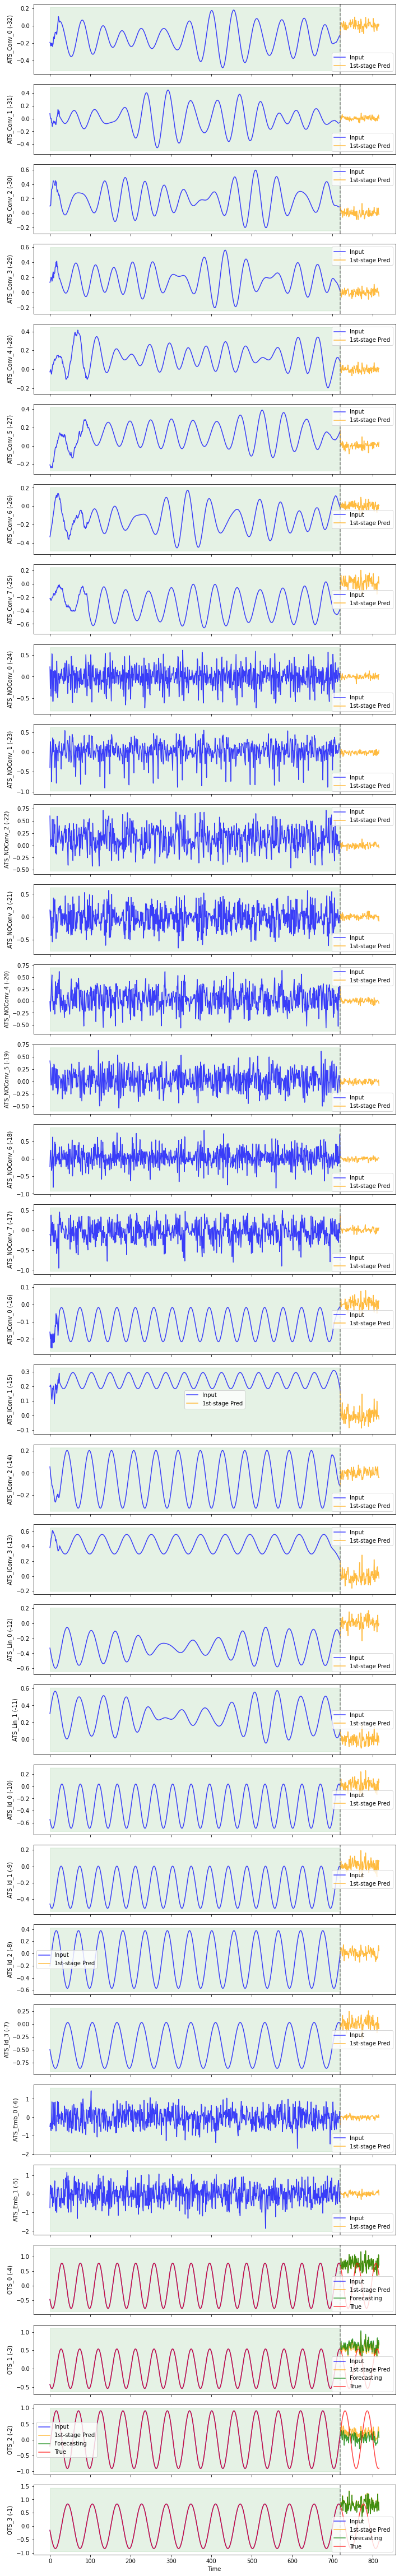

In [6]:
def vis_channel_forecasting(L_I, X, X_adj, X_true, masks, col_names=None):
    """
    Modified function to plot the time series data for visualization with mask highlighting
    that fills the entire vertical range between vmin and vmax.

    Parameters:
    - L_I (int): Length of the input segment.
    - X (torch.Tensor): Tensor containing the preprocessed input and output of the time series model. 
                        (This contains the input and output of the main predictor, recorded in `x_predictor_snapshot`)
                        Shape: (L_I + L_P, C)
    - X_adj (torch.Tensor): Tensor containing the adjusted predictions for a subset of the series.
                            (This is the ATS-adjusted OTS predicton)
                            Shape: (L_P, C_s)
    - X_true (torch.Tensor): Tensor containing the ground truth data.
                             Shape: (L_I + L_P, C_s)
    - masks (torch.Tensor): Tensor containing masking information. Shape: (L_I, C)
                            The cutoff masks provided by temporal sparsity module, visualized in green color
    """
    L_P = X.shape[0] - L_I  # Predicted length
    C = X.shape[1]  # Number of channels (time series)
    C_s = X_adj.shape[1]  # Number of adjusted series

    fig, axs = plt.subplots(C, 1, figsize=(10, 2 * C), sharex=True, dpi=72)
    
    X_adj = torch.cat([X[[L_I-1], -C_s:], X_adj], dim=0)
    
    X = X.detach().cpu().numpy()
    X_adj = X_adj.detach().cpu().numpy()
    X_true = X_true.detach().cpu().numpy()
    masks = masks.detach().cpu().numpy()
    
    # Check if there is only one time series (C == 1)
    if C == 1:
        axs = [axs]

    for i in range(C):
        # Plot input and output for each time series
        axs[i].plot(range(L_I), X[:L_I, i], label='Input', color='blue', alpha=0.75)
        axs[i].plot(range(L_I-1, L_I + L_P), X[(L_I-1):, i], label='1st-stage Pred', color='orange', alpha=0.75)

        # If this series has adjusted predictions and ground truth
        if i >= C - C_s:
            axs[i].plot(range(L_I-1, L_I + L_P), X_adj[:, i - (C - C_s)], label='Forecasting', color='green', alpha=0.75)
            axs[i].plot(range(0, L_I + L_P), X_true[:, i - (C - C_s)], label='True', color='red', alpha=0.75)

        # Draw a vertical line to show the separation between input and output
        axs[i].axvline(x=L_I-1, color='gray', linestyle='--')

        # Find the masking point and fill the area
        t_i = np.where(masks[:, i] == 1)[0][0] if 1 in masks[:, i] else L_I
        ymin, ymax = axs[i].get_ylim()
        axs[i].fill_between(range(t_i, L_I), ymin, ymax, color='green', alpha=0.1)

        # Adding legend and labels
        axs[i].legend()
        if col_names is None or C-i > len(col_names):
            axs[i].set_ylabel(f"Series (-{C-i})")
        else:
            axs[i].set_ylabel(f"{col_names[-(C-i)]} (-{C-i})")

    axs[-1].set_xlabel("Time")
    plt.tight_layout()
    return fig

vis_true = torch.cat([x_i, x_p], dim=0)
n_ATS = x_predictor_snapshot.shape[1] - pred.shape[1]
n_OTS = pred.shape[1]
col_names = [f'ATS_Conv_{i}' for i in range(cats_config.F_conv_output*2)] \
          + [f'ATS_NOConv_{i}' for i in range(cats_config.F_noconv_output*2)] \
          + [f'ATS_IConv_{i}' for i in range(cats_config.F_gconv_output_rate * n_OTS)] \
          + [f'ATS_Lin_{i}' for i in range(cats_config.F_lin_output)] \
          + [f'ATS_Id_{i}' for i in range(cats_config.F_id_output_rate * n_OTS)] \
          + [f'ATS_Emb_{i}' for i in range(cats_config.F_emb_output)] \
          + [f'OTS_{i}' for i in range(n_OTS)]
fig = vis_channel_forecasting(x_i.shape[0], x_predictor_snapshot, pred, vis_true, output_masks, col_names=col_names)
plt.show()

Now, we train for a certain number of epochs on this generated dataset.

Epoch 1,          Average Loss: 0.6444, Total Elapsed Time: 21.04 sec
Epoch 2,          Average Loss: 0.4174, Total Elapsed Time: 2.50 sec
Epoch 3,          Average Loss: 0.3552, Total Elapsed Time: 2.17 sec
Epoch 4,          Average Loss: 0.3053, Total Elapsed Time: 2.33 sec
Epoch 5,          Average Loss: 0.2315, Total Elapsed Time: 2.56 sec
Epoch 6,          Average Loss: 0.1719, Total Elapsed Time: 2.27 sec
Epoch 7,          Average Loss: 0.1356, Total Elapsed Time: 1.50 sec
Epoch 8,          Average Loss: 0.1251, Total Elapsed Time: 1.30 sec
Epoch 9,          Average Loss: 0.1197, Total Elapsed Time: 1.83 sec
Epoch 10,          Average Loss: 0.1138, Total Elapsed Time: 2.12 sec
Epoch 11,          Average Loss: 0.1082, Total Elapsed Time: 2.11 sec
Epoch 12,          Average Loss: 0.1049, Total Elapsed Time: 2.48 sec
Epoch 13,          Average Loss: 0.1010, Total Elapsed Time: 2.14 sec
Epoch 14,          Average Loss: 0.0968, Total Elapsed Time: 2.18 sec
Epoch 15,          Average L

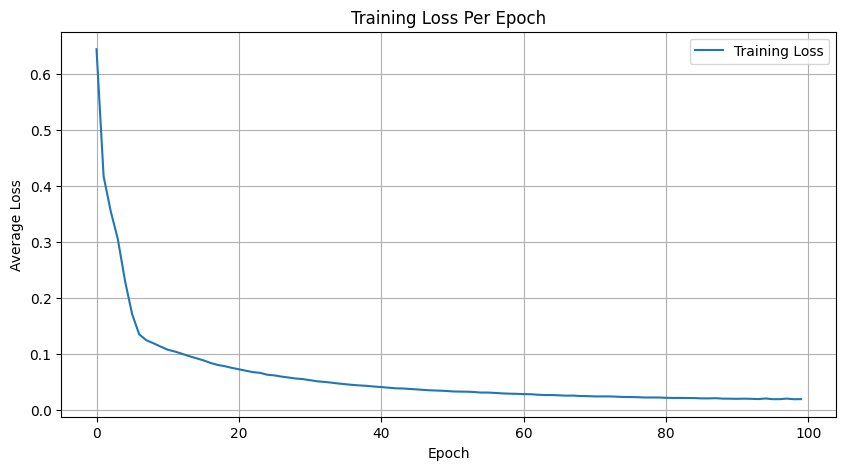

In [7]:
import time

dataloader = torch.utils.data.DataLoader(dataset, batch_size=256, shuffle=True)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
criterion = nn.MSELoss()
num_epochs = 100
model.train()

epoch_losses = []

for epoch in range(num_epochs):
    start_time = time.time()
    total_loss = 0
    num_batches = 0

    for inputs, targets in dataloader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs, cnt_loss = model(inputs, train=True)
        loss = criterion(outputs, targets) + cnt_loss
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        num_batches += 1

        if num_batches % 50 == 0:
            elapsed_time = time.time() - start_time
            print(f'Epoch {epoch+1}, Step {num_batches}, Average Loss: {total_loss / num_batches:.4f}, Elapsed Time: {elapsed_time:.2f} sec')

    average_loss = total_loss / num_batches
    epoch_losses.append(average_loss)
    elapsed_time = time.time() - start_time
    print(f"Epoch {epoch+1},          Average Loss: {average_loss:.4f}, Total Elapsed Time: {elapsed_time:.2f} sec")

# Plotting the training loss curve
plt.figure(figsize=(10, 5))
plt.plot(epoch_losses, label='Training Loss')
plt.title('Training Loss Per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.legend()
plt.grid(True)
plt.show()

Now, we can visualize the performance of the trained model. Here, a different sine wave generator is used to construct a validation sample. This visualization shows that CATS + 2L is able to capture the dynamics of the sine wave dataset.

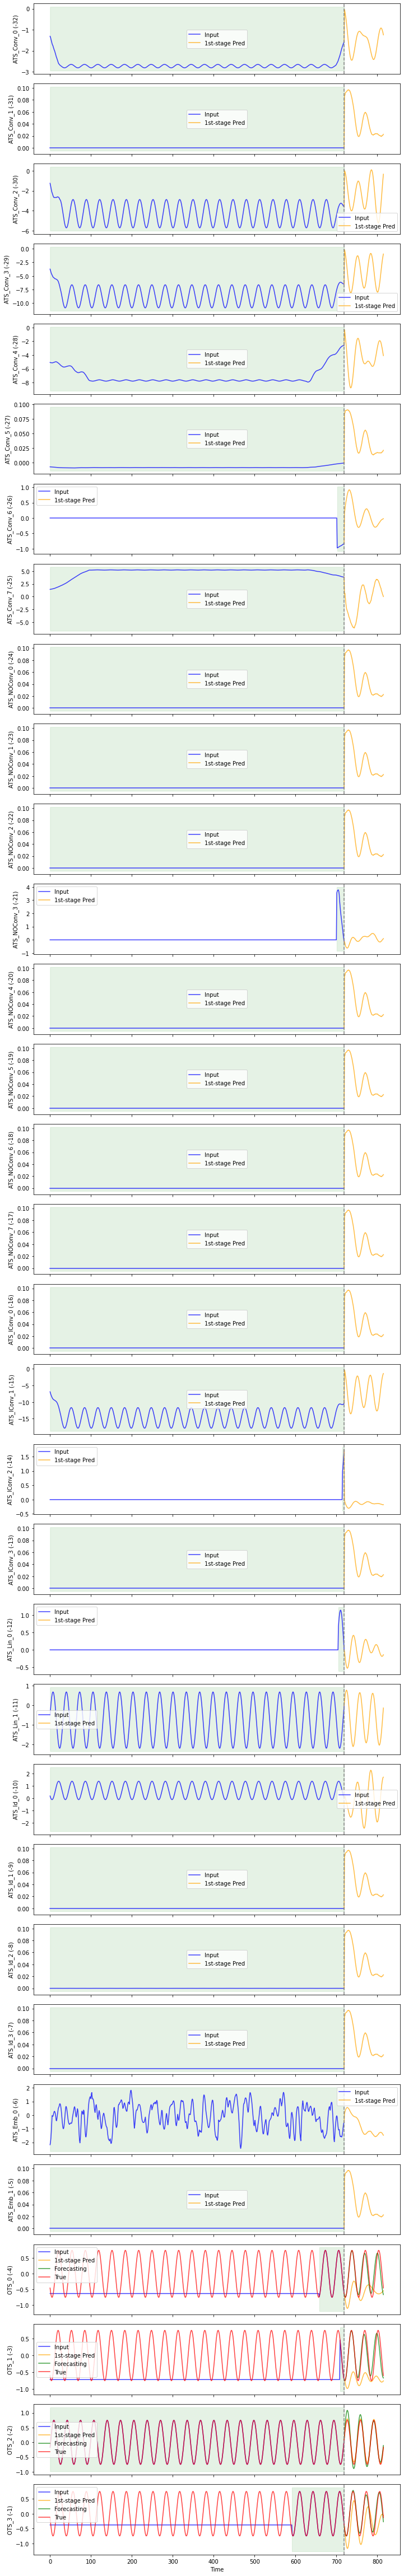

In [8]:
model.eval()

dataset_vali = SineWaveDataset(C=cats_config.enc_in, L_I=cats_config.seq_len, L_P=cats_config.pred_len, frequency_range=(25, 25), amplitude_range=(0.75, 0.75))

x_i, x_p = dataset_vali[0]
with torch.no_grad():
    pred, output_masks, x_predictor_snapshot = model(x_i.to(device).unsqueeze(0), return_mask=True)
pred = pred[0].cpu().detach()
x_predictor_snapshot = x_predictor_snapshot[0].cpu().detach()
output_masks = output_masks[0].cpu().detach()

vis_true = torch.cat([x_i, x_p], dim=0)
n_ATS = x_predictor_snapshot.shape[1] - pred.shape[1]
n_OTS = pred.shape[1]
col_names = [f'ATS_Conv_{i}' for i in range(cats_config.F_conv_output*2)] \
          + [f'ATS_NOConv_{i}' for i in range(cats_config.F_noconv_output*2)] \
          + [f'ATS_IConv_{i}' for i in range(cats_config.F_gconv_output_rate * n_OTS)] \
          + [f'ATS_Lin_{i}' for i in range(cats_config.F_lin_output)] \
          + [f'ATS_Id_{i}' for i in range(cats_config.F_id_output_rate * n_OTS)] \
          + [f'ATS_Emb_{i}' for i in range(cats_config.F_emb_output)] \
          + [f'OTS_{i}' for i in range(n_OTS)]
fig = vis_channel_forecasting(x_i.shape[0], x_predictor_snapshot, pred, vis_true, output_masks, col_names=col_names)
plt.show()

The aforementioned default predictor is a channel-independent predictor with shared parameters. This means that the predictor processes each ATS/OTS independently, using the same predictor parameters for each.

Below, we implement two different examples: Independent Linear and Temporal-channel Aggregation. The Independent Linear assigns an independent subpredictor to each ATS/OTS without shared parameters between them. On the other hand, the Aggregation, a channel-mixing predictor, does not process each ATS/OTS independently but instead mixes their information together to be processed at once by a single predictor.

In [9]:
class IndependentLinearPredictor(nn.Module):
    def __init__(self, d_in, d_out, n_channels, split_ratio=1):	
        super(IndependentLinearPredictor, self).__init__()
        self.model = GroupedLinears(d_in, d_out, n=n_channels, zero_init=False, init=0, split_ratio=split_ratio)
    def forward(self, x, x_mark_enc=None, x_dec=None, x_mark_dec=None):
        # Input: B L C
        x = self.model(x)
        return x

class AggregatingPredictor(nn.Module):
    def __init__(self, d_in, d_out, n_channels, kernel_size=16, token_size=8, dropout=0.5, independent=True):
        super(AggregatingPredictor, self).__init__()
        groups = n_channels if independent else 1
        self.agg = torch.nn.Conv1d(n_channels, token_size * n_channels, kernel_size=kernel_size, stride=kernel_size, groups=groups)
        self.token_dropout = nn.Dropout1d(p=dropout, inplace=False)
        self.predictor = torch.nn.Conv1d(d_in//kernel_size, d_out, kernel_size=token_size, stride=token_size)
    def forward(self, x, x_mark_enc=None, x_dec=None, x_mark_dec=None):
        # Input: B L C
        x = x.permute(0,2,1) # B C L
        x = self.agg(x) # B Ts*C L/Ks
        x = self.token_dropout(x)
        x = x.permute(0,2,1) # B L/Ks Ts*C
        x = self.predictor(x) # B Lp C
        return x

Channel-mixing predictors (like Informer, Autoformer, Aggregation...) are suitable for datasets with stable inter-series dependencies and dynamics; channel-independent predictors with shared parameters (like 2L, PatchTST, DLinear...) are suitable for datasets where inter-series relationships are weak, yet there are shared dynamics and patterns (such as from similar sources); channel-independent predictors with unshared parameters (like Independent Linear) are best for datasets where input series are unrelated and highly variable. We can find that the latter two types of predictors do not attempt to build inter-series relationships in favor of learning intra-series temporal relationships. CATS, however, manages to retain the advantages of learning temporal relationships while also adding the capability to learn inter-series relationships for these predcitors.

From the above analysis, we know that each datapoint in our generated dataset contains sine wave series with similar patterns, and there are no inter-series dependencies in data generation. Thus, a channel-independent predictor with shared parameters is already the most suitable one.

We change the main predictor to Independent Linear to demonstrate its performance. It is evident that these independent single linear layers have lesser fitting capabilities on this dataset compared to 2L.

In [10]:
cats_config = CATSConfig()
cats_config.predictor = 'IndependentLinear'
model = CATS(cats_config).to(device)
if torch.cuda.is_available() and torch.__version__ > '2.0':
    model = torch.compile(model)

Current Predictor: IndependentLinear


Epoch 1,          Average Loss: 0.6673, Total Elapsed Time: 15.08 sec
Epoch 2,          Average Loss: 0.4356, Total Elapsed Time: 1.83 sec
Epoch 3,          Average Loss: 0.3758, Total Elapsed Time: 1.76 sec
Epoch 4,          Average Loss: 0.3488, Total Elapsed Time: 1.97 sec
Epoch 5,          Average Loss: 0.3329, Total Elapsed Time: 2.57 sec
Epoch 6,          Average Loss: 0.3199, Total Elapsed Time: 2.68 sec
Epoch 7,          Average Loss: 0.3096, Total Elapsed Time: 2.25 sec
Epoch 8,          Average Loss: 0.3002, Total Elapsed Time: 1.66 sec
Epoch 9,          Average Loss: 0.2883, Total Elapsed Time: 2.32 sec
Epoch 10,          Average Loss: 0.2776, Total Elapsed Time: 2.50 sec
Epoch 11,          Average Loss: 0.2665, Total Elapsed Time: 2.76 sec
Epoch 12,          Average Loss: 0.2556, Total Elapsed Time: 2.51 sec
Epoch 13,          Average Loss: 0.2431, Total Elapsed Time: 2.40 sec
Epoch 14,          Average Loss: 0.2351, Total Elapsed Time: 2.63 sec
Epoch 15,          Average L

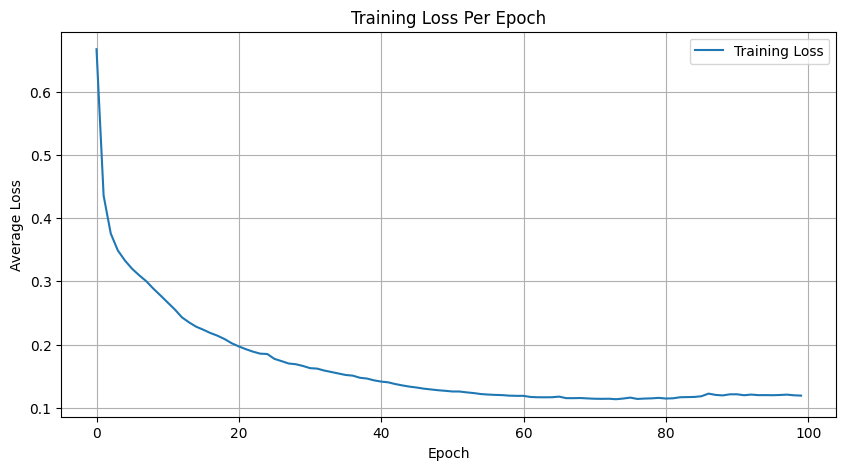

In [11]:
import time

optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
criterion = nn.MSELoss()
num_epochs = 100
model.train()

epoch_losses = []

for epoch in range(num_epochs):
    start_time = time.time()
    total_loss = 0
    num_batches = 0

    for inputs, targets in dataloader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs, cnt_loss = model(inputs, train=True)
        loss = criterion(outputs, targets) + cnt_loss
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        num_batches += 1

        if num_batches % 50 == 0:
            elapsed_time = time.time() - start_time
            print(f'Epoch {epoch+1}, Step {num_batches}, Average Loss: {total_loss / num_batches:.4f}, Elapsed Time: {elapsed_time:.2f} sec')

    average_loss = total_loss / num_batches
    epoch_losses.append(average_loss)
    elapsed_time = time.time() - start_time
    print(f"Epoch {epoch+1},          Average Loss: {average_loss:.4f}, Total Elapsed Time: {elapsed_time:.2f} sec")

# Plotting the training loss curve
plt.figure(figsize=(10, 5))
plt.plot(epoch_losses, label='Training Loss')
plt.title('Training Loss Per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.legend()
plt.grid(True)
plt.show()

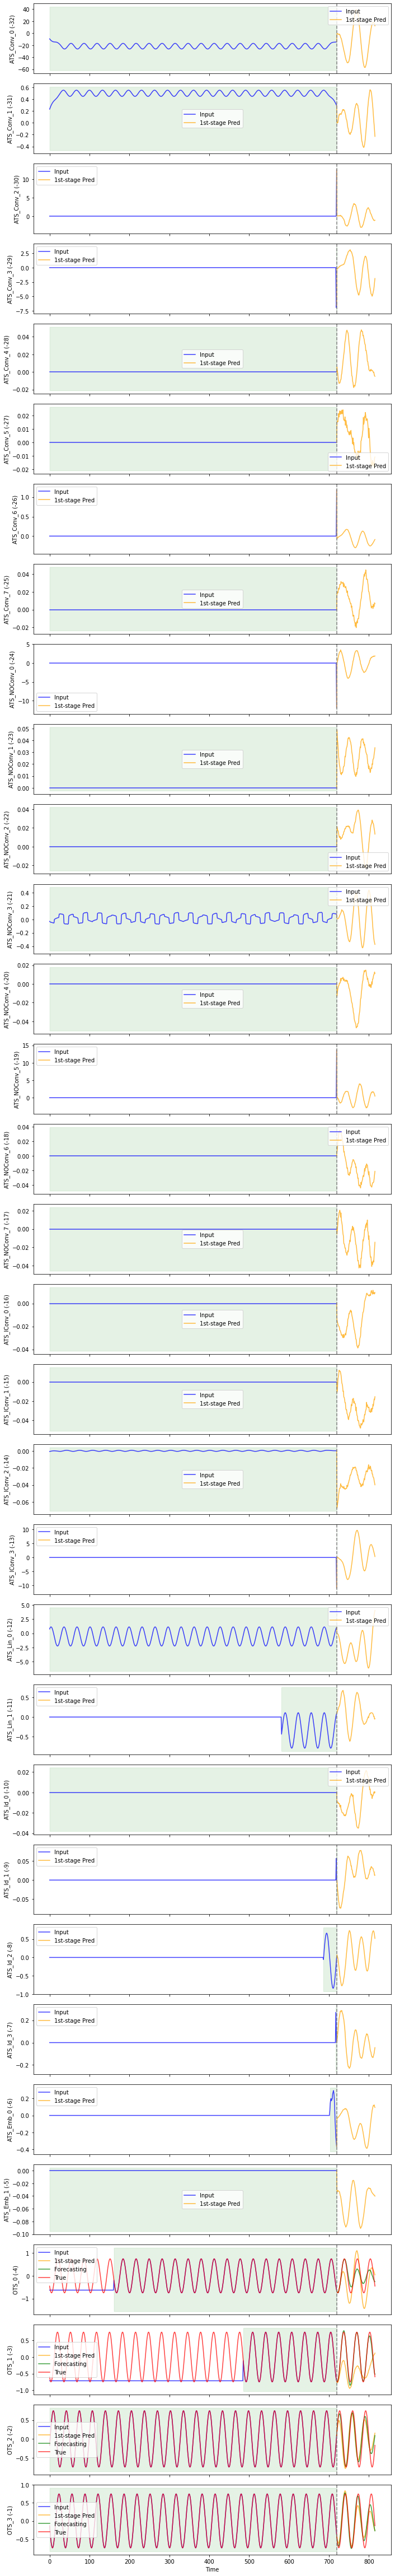

In [12]:
model.eval()

dataset_vali = SineWaveDataset(C=cats_config.enc_in, L_I=cats_config.seq_len, L_P=cats_config.pred_len, frequency_range=(25, 25), amplitude_range=(0.75, 0.75))

x_i, x_p = dataset_vali[0]
with torch.no_grad():
    pred, output_masks, x_predictor_snapshot = model(x_i.to(device).unsqueeze(0), return_mask=True)
pred = pred[0].cpu().detach()
x_predictor_snapshot = x_predictor_snapshot[0].cpu().detach()
output_masks = output_masks[0].cpu().detach()

vis_true = torch.cat([x_i, x_p], dim=0)
n_ATS = x_predictor_snapshot.shape[1] - pred.shape[1]
n_OTS = pred.shape[1]
col_names = [f'ATS_Conv_{i}' for i in range(cats_config.F_conv_output*2)] \
          + [f'ATS_NOConv_{i}' for i in range(cats_config.F_noconv_output*2)] \
          + [f'ATS_IConv_{i}' for i in range(cats_config.F_gconv_output_rate * n_OTS)] \
          + [f'ATS_Lin_{i}' for i in range(cats_config.F_lin_output)] \
          + [f'ATS_Id_{i}' for i in range(cats_config.F_id_output_rate * n_OTS)] \
          + [f'ATS_Emb_{i}' for i in range(cats_config.F_emb_output)] \
          + [f'OTS_{i}' for i in range(n_OTS)]
fig = vis_channel_forecasting(x_i.shape[0], x_predictor_snapshot, pred, vis_true, output_masks, col_names=col_names)
plt.show()

When the characteristics of a dataset are unknown, it's still necessary to test various types of predictors to select the one with the best performance. Although CATS + 2L is a sufficiently balanced choice that adapts well to most datasets, trying more predictors when computational resources allow can lead to more gains.

Tips for training CATS + 2L: Generally, adjusting the parameters of the main predictor yields greater benefits than tuning the parameters of the CATS structure. For 2L, the adjustable parameters are only the dropout rate and the MLP ratio, making it a simple predictor with high tuning benefits. To make the model more generalizable and more regularized, consider increasing the dropout rate or decreasing the MLP ratio. When aiming to enable the model to learn more complex patterns, decrease the dropout rate or increase the MLP ratio.

Below, more implementations of predictors are provided, and you can switch and try them in the configs.

In [13]:
# Channel-independent Linear Predictor with Shared-weights
class SimplePredictor(nn.Module):
    def __init__(self, d_in, d_out):
        super(SimplePredictor, self).__init__()
        self.model = nn.Linear(d_in, d_out)
        
    def forward(self, x, x_mark_enc=None, x_dec=None, x_mark_dec=None):	
        # Input: B L C
        return self.model(x.permute(0,2,1)).permute(0,2,1)

In [14]:
# 3-Layer MLP predictor
class MLPPredictor(nn.Module):
    def __init__(self, d_in, d_ff, d_out, dropout=0.1):	
        super(MLPPredictor, self).__init__()
        self.model = nn.Sequential(nn.Linear(d_in, d_ff),
                                   nn.GELU(),
                                   nn.Dropout(dropout),
                                   nn.Linear(d_ff, d_ff),
                                   nn.GELU(),
                                   nn.Dropout(dropout),
                                   nn.Linear(d_ff, d_out))
        
    def forward(self, x, x_mark_enc=None, x_dec=None, x_mark_dec=None):	
        # Input: B L C
        x = self.model(x.permute(0,2,1)).permute(0,2,1)
        return x

In [15]:
# Simple Mean Predcitor
class MeanAggregationPredictor(nn.Module):
    def __init__(self, pred_len):
        super(MeanAggregationPredictor, self).__init__()
        self.pred_len = pred_len
    def forward(self, x, x_mark_enc=None, x_dec=None, x_mark_dec=None):
        # Input: B L C
        return x.mean(dim=1, keepdim=True).repeat(1, self.pred_len, 1)

In [16]:
# Assign different linear predcitor for different group of ATS/OTS,
# i.e. for ATS/OTS generated from Conv, NOConv, IConv..., assign different linear weights for each of the groups.
class GroupedLinearsAdvanced(nn.Module):
    def __init__(self, in_d, out_d, grouping, zero_init=True, init=0):
        super(GroupedLinearsAdvanced, self).__init__()
        self.grouping = grouping
        self.groups = len(grouping)
        self.group_weights = nn.ParameterList()
        self.group_biases = nn.ParameterList()

        for group_size in grouping:
            weight = nn.Parameter(0.01*torch.randn(group_size, in_d, out_d))  # Group C L Lp
            bias = nn.Parameter(torch.zeros(group_size, 1, out_d))  # Group C 1 Lp
            torch.nn.init.zeros_(weight) if zero_init else None
            self.group_weights.append(weight)
            self.group_biases.append(bias)

        self.init = init

    def forward(self, x):
        # Input: B L C
        x = x.permute(0, 2, 1)  # B C L
        outputs = []

        start = 0
        for i in range(self.groups):
            end = start + self.grouping[i]
            group_x = x[:, start:end]  # B Group C L
            group_x = group_x.unsqueeze(2)  # B Group 1 C L

            w = self.group_weights[i].unsqueeze(0)  # 1 Group C L Lp
            b = self.group_biases[i].unsqueeze(0)  # 1 Group 1 C Lp

            group_x = torch.matmul(group_x, w) + b  # B Group 1 C Lp
            group_x = group_x.squeeze(2)  # B Group C Lp

            outputs.append(group_x)
            start = end

        x = torch.cat(outputs, dim=1)  # B C Lp
        x = x.permute(0, 2, 1)  # B Lp C
        x = x + self.init

        return x
    
class GroupedLinearPredictor(nn.Module):
    def __init__(self, d_in, d_out, grouping):
        super(GroupedLinearPredictor, self).__init__()
        self.model = GroupedLinearsAdvanced(d_in, d_out, grouping=grouping, zero_init=False, init=0)
    def forward(self, x, x_mark_enc=None, x_dec=None, x_mark_dec=None):
        # Input: B L C
        x = self.model(x)
        return x

You can refer to the following GitHub repositories for the implementations of other predictors:

- Informer: https://github.com/zhouhaoyi/Informer2020
- Autoformer: https://github.com/thuml/Autoformer
- DLinear: https://github.com/cure-lab/LTSF-Linear
- PatchTST: https://github.com/yuqinie98/PatchTST
- TimesNet: https://github.com/thuml/Time-Series-Library
- FITS: https://github.com/VEWOXIC/FITS

Most predictors can be easily imported using the following lines:
```python
from models.PatchTST import Model as PatchTST
from models.DLinear import Model as DLinear
from models.Autoformer import Model as Autoformer
from models.Informer import Model as Informer
from models.Transformer import Model as Transformer
from models.TimesNet import Model as TimesNet
from models.TiDE import Model as TiDE
from models.NBeats import Model as NBeats
from models.FITS import Model as FITS
